# Demo to show how to analyze results based on main code output

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 22})
matplotlib.rcParams.update({'lines.linewidth': 4})
import scipy.stats.mstats as mstats
import seaborn as sns
import pandas as pd
from pertdata import PertData_GEARS, PertData_Essential
from utils import aggregated_eval_row, aggregated_eval_col, pred2OE, get_gene_idx
import pickle

## Helper functions

In [2]:
def metric_isbetter(metric, a, b):
    if metric.split('_')[0] in ['mse']:
        return b < a
    else:
        return b > a
    
def metric_worst(metric):
    if metric.split('_')[0] in ['mse']:
        return 1e10
    else:
        return -1e10

all_evals={}

## Load the output files for GARM and GEARS

In [8]:
baselines = ['GARM_bs16', 'GEARS']
epochs = {}
epochs[baselines[0]] = 30
epochs[baselines[1]] = 10
paras = {}
paras[baselines[0]] = ['_layers=2_K=1024']
paras[baselines[1]] = ['_hidden_size=128']
dataname = 'k562'
basic_path = 'results/xxx_yyy_lr=_decay=_para='.replace('xxx',dataname)
lrs = {}
lrs[baselines[0]] = ['1e-3'] #['1e-3','1e-4']
lrs[baselines[1]] = ['1e-3']
decays = {}
decays[baselines[0]]= ['1e-4', '1e-6', '1e-8']
decays[baselines[1]]= ['1e-4', '1e-6', '1e-8'] 
prefix_metrics = ['row-train:', 'row-validation:', 'row-testing:']
prefix_metrics.extend(['col-train:', 'col-validation:', 'col-testing:'])
prefix_metrics.extend(['OE-row-train:', 'OE-row-validation:', 'OE-row-testing:'])
prefix_metrics.extend(['OE-col-train:', 'OE-col-validation:', 'OE-col-testing:'])
metrics = ['mse', 'pearson', 'spearman','auroc_up','auprc_up','auroc_down','auprc_down']
results = {}
for baseline in baselines:
    results[baseline] = {}
    tmp_lrs = lrs[baseline]
    tmp_decays = decays[baseline]
    print(baseline)
    if baseline == 'GEARS':
        basic_path = basic_path.replace('replogle','curated').replace('_essential','')   
    for decay in tmp_decays:
        results[baseline][decay] = {}
        for lr in tmp_lrs:
            results[baseline][decay][lr] = {}
            for para in paras[baseline]:
                results[baseline][decay][lr][para] = {}    
                for prefix in prefix_metrics:
                    res = {}
                    for metric in metrics:
                        res[metric] = []
                    if dataname.split('_')[0] == 'replogle' and baseline == 'GARM_bs16':
                        fpath = basic_path.replace('yyy', 'NNatt16').replace('lr=','lr='+lr).replace('decay=','decay='+decay)
                    else:
                        fpath = basic_path.replace('yyy', baseline).replace('lr=','lr='+lr).replace('decay=','decay='+decay)
                    fpath = fpath.replace('_para=', para)
                    f = open(fpath, "r")
                    while(True):
                        line = f.readline()
                        if not line:
                            break
                        elems = line.split(' ')
                        if elems[0] == prefix:
                            metric = None
                            for elem in elems:
                                value = elem.strip('\n').strip('{').strip('}').strip(':').strip('\'').strip(',')
                                if metric is not None:
                                    res[metric].append(float(value))
                                    metric = None
                                if value in metrics:
                                    metric = value
                                
                    for metric in metrics:
                        num_values = 5 * epochs[baseline]
                        if len(res[metric]) == num_values:
                            res[metric] = np.array(res[metric]).reshape(5, -1)
                        else:
                            N = num_values - len(res[metric])
                            res[metric] = np.concatenate([np.array(res[metric]), np.ones(N)*metric_worst(metric)], axis=0).reshape(5, -1)
                            print(prefix,metric,fpath)
                    results[baseline][decay][lr][para][prefix] = res
# print(results)

GARM_bs16
GEARS


## Tabular results

In [11]:
evals = {}
replicas, _ = res[metric].shape
params = {}
for prefix in prefix_metrics:
    evals[prefix] = {}
    params[prefix] = {}
    for metric in metrics:
        evals[prefix][metric] = {}
        params[prefix][metric] = {}
        for baseline in baselines:
            evals[prefix][metric][baseline] = np.ones(5)*metric_worst(metric)
            params[prefix][metric][baseline] = {}
            if prefix in ['row-testing:', 'col-testing:', 'OE-row-testing:', 'OE-col-testing:']:
                evals[prefix.replace('testing:','validation:')][metric][baseline] = np.ones(5)*metric_worst(metric)
            for replica in range(replicas): 
                params[prefix][metric][baseline][replica]={}
                params[prefix][metric][baseline][replica]['decay']=-1
                params[prefix][metric][baseline][replica]['lr']=-1
                params[prefix][metric][baseline][replica]['para']=-1
                for decay in decays[baseline]:
                    for lr in lrs[baseline]:
                        for para in paras[baseline]:
                            for i in range(epochs[baseline]):
                                if prefix in ['row-testing:', 'col-testing:', 'OE-row-testing:', 'OE-col-testing:']:
                                    current = results[baseline][decay][lr][para][prefix.replace('testing:','validation:')][metric][replica, i]
                                    old = evals[prefix.replace('testing:','validation:')][metric][baseline][replica]
                                else:
                                    current = results[baseline][decay][lr][para][prefix][metric][replica, i]
                                    old = evals[prefix][metric][baseline][replica]
                                if metric_isbetter(metric, old, current):
                                    current_test = results[baseline][decay][lr][para][prefix][metric][replica, i]
                                    if prefix in ['row-testing:', 'col-testing:', 'OE-row-testing:', 'OE-col-testing:']:
                                        evals[prefix.replace('testing:','validation:')][metric][baseline][replica] = current
                                    evals[prefix][metric][baseline][replica] = current_test
                                    params[prefix][metric][baseline][replica]['decay'] = decay
                                    params[prefix][metric][baseline][replica]['lr'] = lr
                                    params[prefix][metric][baseline][replica]['para'] = para


# print(evals)
# print(params)

# for prefix in prefix_metrics:
#     print('+'*20+prefix+'+'*20)
#     for metric in metrics:
#         output = ''
#         for baseline in baselines:
#             values = evals[prefix][metric][baseline]
#             mean = np.around(np.mean(values), 4)
#             std = np.around(np.std(values), 4)
#             out = str(mean) + '(' + str(std) + ')\t'
#             output += out
#         print(output)

# print('learning rate:')
# for prefix in prefix_metrics:
#     print('+'*20+prefix+'+'*20)
#     for metric in metrics:
#         output = ''       
#         for baseline in baselines:
#             values = []
#             for replica in range(replicas):
#                 value = float(params[prefix][metric][baseline][replica]['lr'])
#                 out = str(value) + '\t'
#                 output += out
#                 values.append(value)
#                 # print(value)
#             mean = np.around(np.mean(values), 3)
#             std = np.around(np.std(values), 3)
#             output += str(mean) + '(' + str(std) + ')\t'
#         print(output)

# print('weight decay:')
# for prefix in prefix_metrics:
#     print('+'*20+prefix+'+'*20)
#     for metric in metrics:
#         output = ''        
#         for baseline in baselines:
#             values = []
#             for replica in range(replicas):
#                 value = float(params[prefix][metric][baseline][replica]['decay'])
#                 out = str(value) + '\t'
#                 output += out
#                 values.append(value)
#             mean = np.around(np.mean(values), 3)
#             std = np.around(np.std(values), 3)
#             output += str(mean) + '(' + str(std) + ')\t'
#         print(output)
        

tmp_prefix = ['row-testing:', 'col-testing:', 'OE-row-testing:', 'OE-col-testing:']

oneline = ''
all_evals[dataname]={}
for baseline in baselines:
    print('+'*20+baseline+'+'*20)
    ct = 0
    all_evals[dataname][baseline]={}
    for prefix in tmp_prefix:
        output = ''
        all_evals[dataname][baseline][prefix]={}
        for metric in metrics:
            values = evals[prefix][metric][baseline]
            all_evals[dataname][baseline][prefix][metric]=values
            mean = np.around(np.mean(values), 4)
            std = np.around(np.std(values), 4)
            out = str(mean) + '(' + str(std) + ')\t'
            output += out
            ct += 1
            if ct not in [8, 22]:
                oneline += out
        print(output)
    oneline += '\n'
# print(oneline)

++++++++++++++++++++GARM_bs16++++++++++++++++++++
0.0429(0.0007)	0.2934(0.0082)	0.2662(0.0072)	0.625(0.0028)	0.3335(0.0069)	0.6581(0.0046)	0.3738(0.0052)	
0.0429(0.0007)	0.2866(0.0101)	0.2349(0.0067)	0.6197(0.0051)	0.3324(0.0129)	0.6242(0.0029)	0.3312(0.0078)	
0.008(0.0003)	0.3314(0.0087)	0.3221(0.0069)	0.6625(0.0052)	0.3898(0.0078)	0.6656(0.0035)	0.4132(0.0058)	
0.008(0.0003)	0.4385(0.027)	0.3503(0.0142)	0.6875(0.0051)	0.4258(0.0208)	0.6931(0.0127)	0.4012(0.018)	
++++++++++++++++++++GEARS++++++++++++++++++++
0.0517(0.0002)	0.1907(0.0046)	0.1719(0.0049)	0.5772(0.0033)	0.2763(0.0039)	0.6032(0.0014)	0.3045(0.0035)	
0.0517(0.0002)	0.1815(0.0103)	0.142(0.0077)	0.5757(0.0046)	0.2826(0.0086)	0.5758(0.0037)	0.2822(0.0038)	
0.009(0.0002)	0.2401(0.0061)	0.2374(0.006)	0.617(0.0022)	0.3354(0.0035)	0.6235(0.0044)	0.3542(0.0043)	
0.009(0.0002)	0.3655(0.0173)	0.2743(0.0102)	0.6464(0.0086)	0.365(0.0183)	0.6435(0.0184)	0.368(0.019)	


## Load the output files for Coexpress, scGPT and GenePert

In [12]:
baselines = ['coexpress', 'scgpt', 'genept']
paras = {}
paras[baselines[0]] = ['_K=32','_K=64','_K=128'] 
paras[baselines[1]] = ['']
paras[baselines[2]] = ['']
basic_path = 'results/xxx_yyy_para=_decay='.replace('xxx',dataname)
lrs = ['']
decays = ['1e4','1e3', '1e2', '1e1', '1e0', '1e-1', '1e-2', '1e-3', '1e-4', '1e-5', '1e-6']
prefix_metrics = ['row-train:', 'row-validation:', 'row-testing:']
prefix_metrics.extend(['col-train:', 'col-validation:', 'col-testing:'])
prefix_metrics.extend(['OE-row-train:', 'OE-row-validation:', 'OE-row-testing:'])
prefix_metrics.extend(['OE-col-train:', 'OE-col-validation:', 'OE-col-testing:'])
metrics = ['mse', 'pearson', 'spearman','auroc_up','auprc_up','auroc_down','auprc_down']
results = {}
for baseline in baselines:
    results[baseline] = {}
    tmp_lrs = lrs
    tmp_decays = decays
    print(baseline)
    for decay in tmp_decays:
        results[baseline][decay] = {}
        for lr in tmp_lrs:
            results[baseline][decay][lr] = {}
            for para in paras[baseline]:
                results[baseline][decay][lr][para] = {}    
                for prefix in prefix_metrics:
                    res = {}
                    for metric in metrics:
                        res[metric] = []
                    fpath = basic_path.replace('yyy', baseline).replace('decay=','decay='+decay)
                    fpath = fpath.replace('layers=', 'layers=4').replace('_para=', para)
                    f = open(fpath, "r")
                    while(True):
                        line = f.readline()
                        if not line:
                            break
                        elems = line.split(' ')
                        if elems[0] == prefix:
                            metric = None
                            for elem in elems:
                                value = elem.strip('\n').strip('{').strip('}').strip(':').strip('\'').strip(',')
                                if metric is not None:
                                    res[metric].append(float(value))
                                    metric = None
                                if value in metrics:
                                    metric = value
                                
                    for metric in metrics:
                        try:
                            res[metric] = np.array(res[metric]).reshape(5, -1)
                        except:
                            print(fpath)
                    results[baseline][decay][lr][para][prefix] = res
# print(results)

coexpress
scgpt
genept


## Tabular results

In [14]:
evals = {}
replicas, epochs = res[metric].shape
params = {}
for prefix in prefix_metrics:
    evals[prefix] = {}
    params[prefix] = {}
    for metric in metrics:
        evals[prefix][metric] = {}
        params[prefix][metric] = {}
        for baseline in baselines:
            evals[prefix][metric][baseline] = np.ones(5)*metric_worst(metric)
            params[prefix][metric][baseline] = {}
            if prefix in ['row-testing:', 'col-testing:', 'OE-row-testing:', 'OE-col-testing:']:
                evals[prefix.replace('testing:','validation:')][metric][baseline] = np.ones(5)*metric_worst(metric)
            for replica in range(replicas): 
                params[prefix][metric][baseline][replica]={}
                params[prefix][metric][baseline][replica]['decay']=-1
                params[prefix][metric][baseline][replica]['lr']=-1
                params[prefix][metric][baseline][replica]['para']=-1
                for decay in decays:
                    for lr in lrs:
                        for para in paras[baseline]:
                            for i in range(epochs):
                                if prefix in ['row-testing:', 'col-testing:', 'OE-row-testing:', 'OE-col-testing:']:
                                    current = results[baseline][decay][lr][para][prefix.replace('testing:','validation:')][metric][replica, i]
                                    old = evals[prefix.replace('testing:','validation:')][metric][baseline][replica]
                                else:
                                    current = results[baseline][decay][lr][para][prefix][metric][replica, i]
                                    old = evals[prefix][metric][baseline][replica]
                                if metric_isbetter(metric, old, current):
                                    current_test = results[baseline][decay][lr][para][prefix][metric][replica, i]
                                    if prefix in ['row-testing:', 'col-testing:', 'OE-row-testing:', 'OE-col-testing:']:
                                        evals[prefix.replace('testing:','validation:')][metric][baseline][replica] = current
                                    evals[prefix][metric][baseline][replica] = current_test
                                    params[prefix][metric][baseline][replica]['decay'] = decay
                                    params[prefix][metric][baseline][replica]['lr'] = lr
                                    params[prefix][metric][baseline][replica]['para'] = para


# print(evals)
# print(params)

# for prefix in prefix_metrics:
#     print('+'*20+prefix+'+'*20)
#     for metric in metrics:
#         output = ''
#         for baseline in baselines:
#             values = evals[prefix][metric][baseline]
#             mean = np.around(np.mean(values), 4)
#             std = np.around(np.std(values), 4)
#             out = str(mean) + '(' + str(std) + ')\t'
#             output += out
#         print(output)

# print('Hyper parameter:')
# for prefix in prefix_metrics:
#     print('+'*20+prefix+'+'*20)
#     for metric in metrics:
#         output = ''       
#         for baseline in baselines:
#             values = []
#             for replica in range(replicas):
#                 value = params[prefix][metric][baseline][replica]['para'].split('=')[-1]
#                 try:
#                     value = float(value)
#                 except:
#                     value = 'NA'
#                 out = str(value) + '\t'
#                 output += out
#                 values.append(value)
#             if isinstance(value, str):
#                 mean = 'NA'
#                 std = 'NA'
#             else:
#                 mean = np.around(np.mean(values), 3)
#                 std = np.around(np.std(values), 3)
#             output += str(mean) + '(' + str(std) + ')\t'
#         print(output)

# print('weight decay:')
# for prefix in prefix_metrics:
#     print('+'*20+prefix+'+'*20)
#     for metric in metrics:
#         output = ''        
#         for baseline in baselines:
#             values = []
#             for replica in range(replicas):
#                 value = float(params[prefix][metric][baseline][replica]['decay'])
#                 out = str(value) + '\t'
#                 output += out
#                 values.append(value)
#             mean = np.around(np.mean(values), 3)
#             std = np.around(np.std(values), 3)
#             output += str(mean) + '(' + str(std) + ')\t'
#         print(output)
        

tmp_prefix = ['row-testing:', 'col-testing:', 'OE-row-testing:', 'OE-col-testing:']

oneline = ''
for baseline in baselines:
    all_evals[dataname][baseline]={}
    print('+'*20+baseline+'+'*20)
    ct = 0
    for prefix in tmp_prefix:
        all_evals[dataname][baseline][prefix]={}
        output = ''
        for metric in metrics:
            values = evals[prefix][metric][baseline]
            all_evals[dataname][baseline][prefix][metric]=values
            mean = np.around(np.mean(values), 4)
            std = np.around(np.std(values), 4)
            out = str(mean) + '(' + str(std) + ')\t'
            output += out
            ct += 1
            if ct not in [8, 22]:
                oneline += out
        print(output)
    oneline += '\n' # convert to the table with the format in paper.
# print(oneline)

++++++++++++++++++++coexpress++++++++++++++++++++
0.0465(0.0007)	0.2545(0.0073)	0.2296(0.0066)	0.591(0.0032)	0.2937(0.004)	0.6505(0.0042)	0.3559(0.0056)	
0.0465(0.0007)	0.1332(0.0113)	0.1042(0.0101)	0.5621(0.0057)	0.2711(0.0065)	0.5504(0.0063)	0.2378(0.0055)	
0.0092(0.0002)	0.2932(0.0072)	0.2875(0.0069)	0.6405(0.0034)	0.355(0.0037)	0.6505(0.0042)	0.3883(0.0055)	
0.0092(0.0002)	0.2064(0.018)	0.164(0.0072)	0.5985(0.0132)	0.3254(0.0149)	0.5742(0.0119)	0.2533(0.0169)	
++++++++++++++++++++scgpt++++++++++++++++++++
0.0461(0.0007)	0.2523(0.0072)	0.2274(0.0072)	0.5899(0.003)	0.2914(0.0027)	0.6516(0.004)	0.356(0.005)	
0.0461(0.0007)	0.141(0.0072)	0.1198(0.003)	0.5678(0.003)	0.2771(0.0061)	0.5588(0.0019)	0.2407(0.0008)	
0.009(0.0002)	0.2934(0.008)	0.2866(0.0075)	0.6393(0.0036)	0.3546(0.0045)	0.651(0.0044)	0.3883(0.0051)	
0.009(0.0002)	0.2422(0.0178)	0.1985(0.0153)	0.6172(0.0128)	0.3459(0.0118)	0.5937(0.0125)	0.2565(0.0083)	
++++++++++++++++++++genept++++++++++++++++++++
0.0438(0.0008)	0.2898(0.0

## Bar plots for overall comparison

['GEARS', 'coexpress', 'scgpt', 'genept', 'GARM_bs16']
2.446980482836534e-07
1.8208559131039798e-08
5.701163433078713e-09
6.219513767617364e-05
4.293331716159844e-08
1.1275431922745232e-08
5.857216716403848e-10
2.9794963842898533e-05
4.321720847514096e-09
3.933505403182237e-05
9.9366581717478e-05
0.04954460836474961


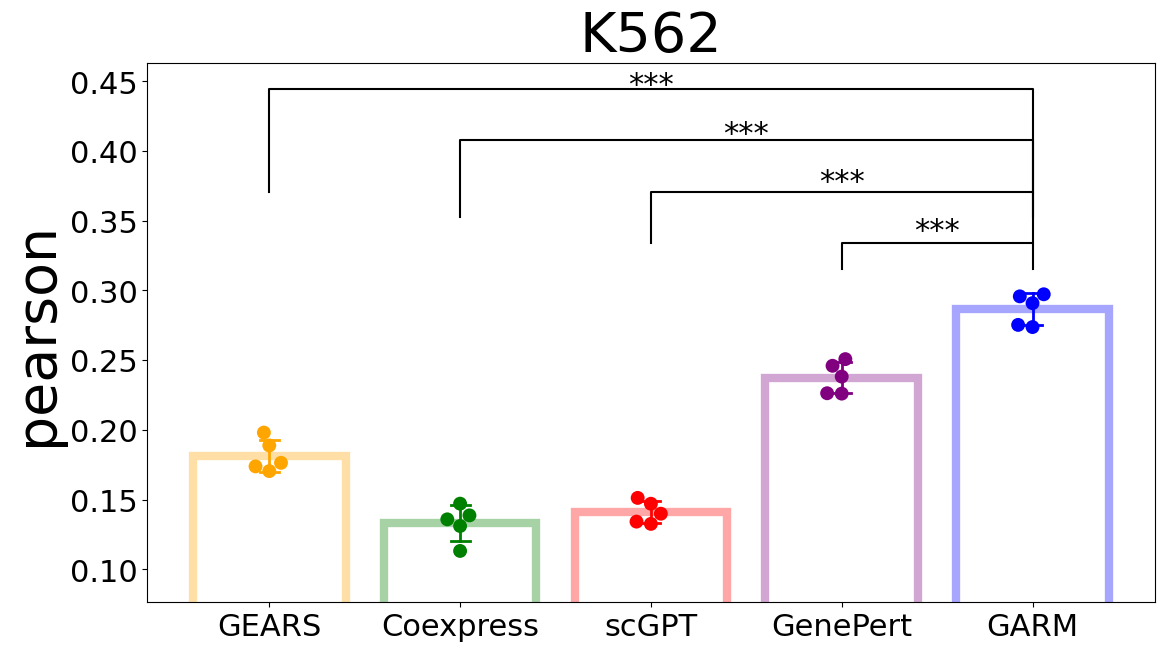

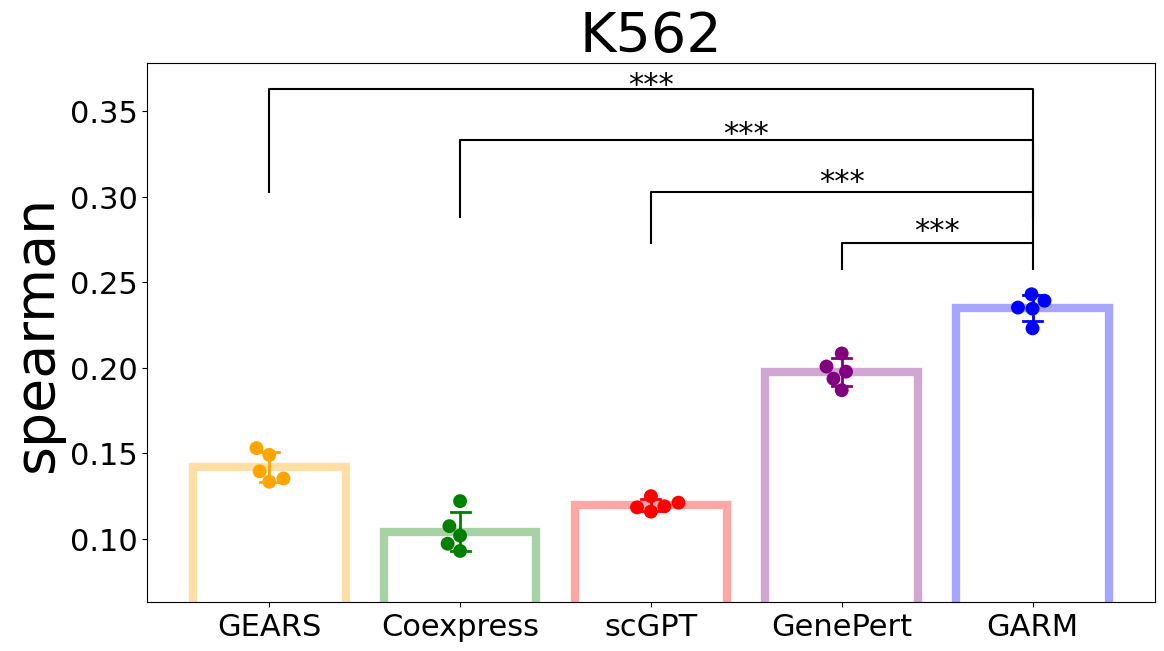

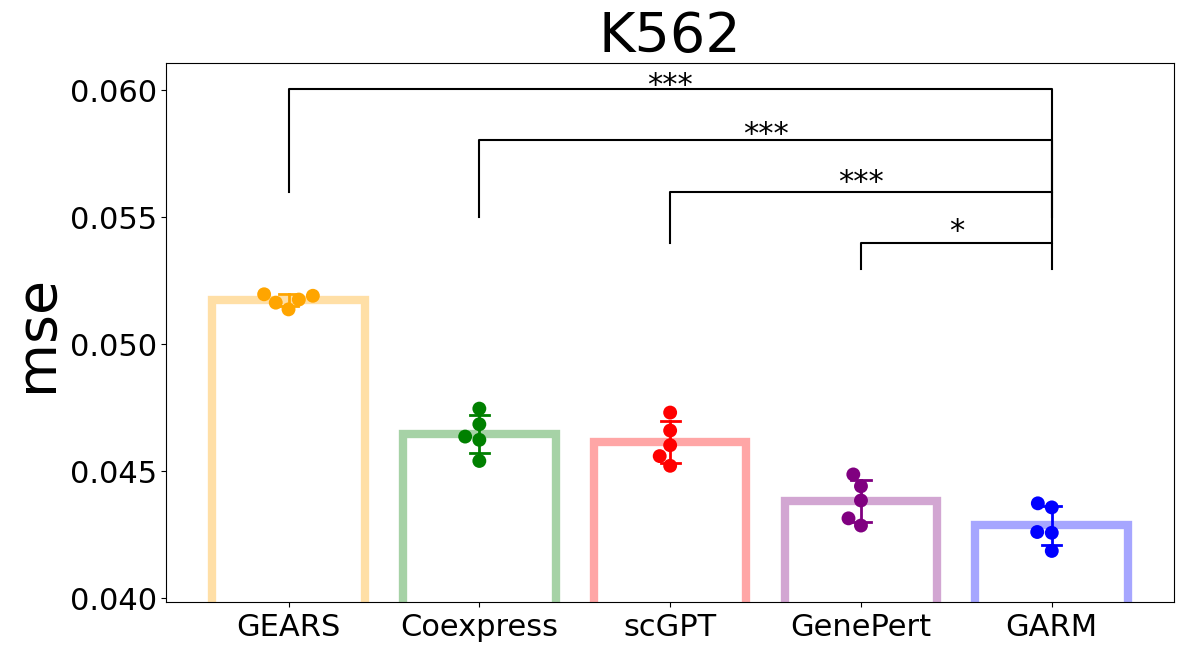

In [21]:
method_map = {'GARM_bs16': 'GARM', 'GEARS':'GEARS', 'coexpress':'Coexpress', 'scgpt':'scGPT', 'genept':'GenePert'}
baselines = ['GEARS', 'coexpress', 'scgpt', 'genept', 'GARM_bs16']
print(baselines)
metric_map = {'mse': 'MSE', 'pearson':'Pearson', 'spearman':'Spearman'}
data_map = {'hepg2':'HepG2', 'jurkat':'Jurkat', 'k562':'K562', 'rpe1':'RPE1', 
            'replogle_k562_essential':'Curated K562', 'replogle_rpe1_essential':'Curated RPE1', 'adamson':'Adamson'}

prefix = 'col-testing:'
os_ttest = {'pearson': 'greater', 'spearman': 'greater', 'mse': 'less'}
for metric in ['pearson', 'spearman', 'mse']:
    for dataset in all_evals.keys():
        tmp_dict = all_evals[dataset]
        rows = []
        for method in baselines: #tmp_dict.items():
            j = tmp_dict[method]
            for value in j[prefix][metric]:
                rows.append({'method': method_map[method], metric: value})
    
        df = pd.DataFrame(rows)
        # print(df)
        plt.figure(figsize=(13,7))
        my_pal = {'GARM': 'blue', 'GEARS':'orange', 'Coexpress':'green', 'scGPT':'red', 'GenePert':'purple'}
        ax = sns.barplot(data=df, x="method", hue="method", y=metric, capsize=.1, err_kws={'linewidth': 2}, errorbar='sd', palette=my_pal, fill=False, alpha=.35)
        ax = sns.swarmplot(data=df, x="method", hue="method", y=metric, palette=my_pal, size=10)
        ax.set_title(data_map[dataset], fontsize=40)
        ax.set_ylabel(metric, fontsize=40)
        ax.set_xlabel('')
        # ax.set_xticks('')
        
        xs = []
        heights = []
        for p in ax.patches:
            # Get the x, y coordinates and the width and height of the rectangle
            x = p.get_x()
            y = p.get_y()
            width = p.get_width()
            height = p.get_height()
            xs.append(x+0.5*width)
            heights.append(height)
        ct = 0
        for collection in ax.collections:
            if isinstance(collection, matplotlib.collections.PathCollection):
                # Get the x and y coordinates of the plotted points
                offsets = collection.get_offsets()
                x_coordinates = offsets[:, 0]
                y_coordinates = offsets[:, 1]
                if max(y_coordinates) > heights[ct]:
                    heights[ct] = max(y_coordinates)
                ct += 1
                
        for i in range(0,4):
            v1 = tmp_dict[baselines[-1]]['col-testing:'][metric]
            v2 = tmp_dict[baselines[i]]['col-testing:'][metric]
            ttest = mstats.ttest_ind(v1, v2, alternative=os_ttest[metric])
            print(ttest.pvalue)
            x1, x2 = xs[-1], xs[i]   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
            unit = (df[metric].max()-df[metric].min())*0.1*(4-i)
            y, h, col = max(heights) + unit, unit, 'k'
            plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
            if ttest.pvalue >= 0.05:
                plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col)
            elif ttest.pvalue >= 0.001:
                plt.text((x1+x2)*.5, y+0.9*h, "*", ha='center', va='bottom', color=col)
            elif ttest.pvalue >= 0.0001:
                plt.text((x1+x2)*.5, y+0.9*h, "**", ha='center', va='bottom', color=col)
            else:
                plt.text((x1+x2)*.5, y+0.9*h, "***", ha='center', va='bottom', color=col)
        ax.set_ylim([df[metric].min()-2*h, y+8*h])
        # name = 'within_'+prefix.replace(':','')+'_'+data_map[dataset].replace(' ', '_')+'_'+metric+'.pdf'
        # plt.savefig('figures/pdfs/bar-dots/'+name,format='pdf')